### <b>Solving 2d Laplace equation via Phycisc Informed Neural Networks (PINNs)<b>

This notebook gives an example of how a a Phycisc Informed Neural Network (PINN) can be easily and quickly used with the TensorFlow (TF) .fit method. 

This approach is used to solve the 2d Laplace equation on a square domain [-1,1]$\times$[-1,1].

For a detailed description of the method, as well as to have further details, please refer to the <a href=https://github.com/maziarraissi/PINNs>following repo</a>, and to:
<ul>
  <li>Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis. <a href=https://www.sciencedirect.com/science/article/pii/S0021999118307125>Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations</a> Journal of Computational Physics 378 (2019): 686-707.</li>
  <li>Raissi, Maziar, Paris Perdikaris, and George Em Karniadakis. <a href=https://arxiv.org/abs/1711.10561>Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations</a> arXiv preprint arXiv:1711.10561 (2017).</li>
  <li>Raissi, Maziar, Paris Perdikaris, and George Em Karniadakis. <a href=https://arxiv.org/abs/1711.10566>Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations</a> arXiv preprint arXiv:1711.10566 (2017).</li>
</ul> 

Import the required libraries. The <a href=https://py-pde.readthedocs.io/en/latest/index.html>*py-pde*</a> package is used here to compute the reference solution.

In [9]:
import numpy as np
from sklearn import preprocessing 
import tensorflow as tf
from matplotlib import pyplot as plt
plt.close('all')

import seaborn as sns
sns.set_style("darkgrid")

from datetime import datetime
from pde import CartesianGrid, solve_laplace_equation

Define the computational geometry (square domain $\Omega$ = [-1,1]$\times$[-1,1]) and the *collocation poits*, that are the points inside $\Omega$ where the physical contraint is enforced. 

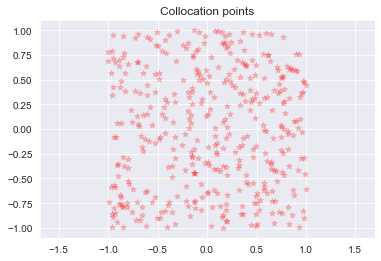

In [10]:
lb = np.array([-1,1])
ub = np.array([-1,1])

box = np.array([[-1, -1], 
                [1, -1],
                [1, 1],
                [-1, 1]])

# define collocation points
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
N_rand = 20**2
coll_pts = np.column_stack((scaler.fit_transform(np.random.rand(N_rand).reshape(-1,1)),
                          scaler.fit_transform(np.random.rand(N_rand).reshape(-1,1))))

plt.figure()
plt.scatter(coll_pts[:,0],coll_pts[:,1], c='r', marker='*', alpha=0.2)
plt.axis('equal')
plt.title('Collocation points')
plt.show()

Compute the reference solunion via *py-pde* package.

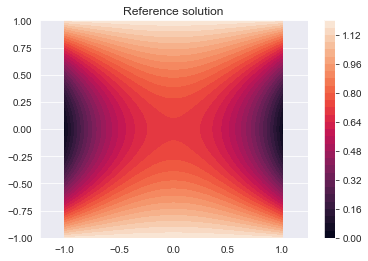

In [11]:
# define a Cartesian Grid for the solution
grid = CartesianGrid([[-1.1, 1.1]] * 2, 50)
bcs = [{"value": "sin(y)"}, {"value": "sin(x)"}]
bcs = [{"value": "x**2"}, {"value": "x**2"}]

# solve and plot the solution
res = solve_laplace_equation(grid, bcs)

x_BCs = np.linspace(-1,1,50).T
y_BCd = np.linspace(-1,1,50).T
x, y = np.meshgrid(x_BCs, y_BCd)

plt.figure()
plt.contourf(x,y,res.data,30)
plt.axis('equal')
plt.colorbar()
plt.title('Reference solution')
plt.show()

Define the input/output for training the the Deep Neural Network (DNN), i.e., `X_train` are the $(x,y)$ coordinates of the boundary points and `y_train` are the values of the function at these points. Moreover, we define also `X_r`, the vector of the $(x,y)$ coordinates of the collocation points.

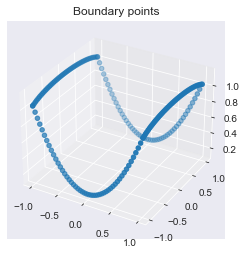

In [12]:
BCs_pts = np.row_stack((np.column_stack((x_BCs,-np.ones_like(x_BCs))),
                       np.column_stack((np.ones_like(x_BCs),x_BCs)),
                       np.column_stack((np.flipud(x_BCs),np.ones_like(x_BCs))),
                       np.column_stack((-np.ones_like(x_BCs),np.flipud(x_BCs)))))


BCs_vals = res.interpolate(BCs_pts)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(BCs_pts[:,0],BCs_pts[:,1],BCs_vals,marker = 'o')
plt.title('Boundary points')


# Define inputs/outputs for training
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE) # Set data type for TF

X_r    = tf.constant(coll_pts, dtype=DTYPE)   # -> collocation points
X_train = tf.constant(BCs_pts, dtype=DTYPE)   # -> boundary points
y_train = tf.constant(BCs_vals.reshape(-1,1), dtype=DTYPE)  #-> values of function at boundary points

n_input = 2
n_output = 1

Define the Neural Network model and the routines for the custom cost function `PINN_cost`.

In [13]:
# Define residual of the PDE
def fun_r(u_xx, u_yy):
    return u_xx + u_yy


# compute the partial derivatives w.r.t. x and y coordinates via tf.GradientTape
def get_r(model, X_r):
    with tf.GradientTape() as g:
        x,y = X_r[:,-2], X_r[:,-1]
        g.watch(x)
        with tf.GradientTape(persistent=False) as gg:
            gg.watch(x)
            u = model(tf.stack([x, y], axis=1))
        u_x = gg.gradient(u, x)  
    u_xx = g.gradient(u_x, x) 
    del g, gg
    
    with tf.GradientTape() as g:
        x,y = X_r[:,-2], X_r[:,-1]
        g.watch(y)
        with tf.GradientTape(persistent=False) as gg:
            gg.watch(y)
            u = model(tf.stack([x, y], axis=1))
        u_y = gg.gradient(u, y)  
    u_yy = g.gradient(u_y, y) 
    del g, gg
    
    return fun_r(u_xx, u_yy)


# custom cost function
def PINN_cost(y_true, y_pred):  
    # residue due to PDE
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
        
    # loss of DNN
    loss_DNN = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # total cost
    cost = phi_r + loss_DNN
    return cost


# init neural network model
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(n_input,))

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('swish'),
            kernel_initializer=tf.keras.initializers.HeNormal(seed=None)))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

Train the model on the dataset `X_train`, `y_train`

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 20)                60        
                                                                 
 dense_28 (Dense)            (None, 20)                420       
                                                                 
 dense_29 (Dense)            (None, 20)                420       
                                                                 
 dense_30 (Dense)            (None, 20)                420       
                                                                 
 dense_31 (Dense)            (None, 20)                420       
                                                                 
 dense_32 (Dense)            (None, 20)                420       
                                                                 
 dense_33 (Dense)            (None, 20)               

Text(0.5, 1.0, 'Training history')

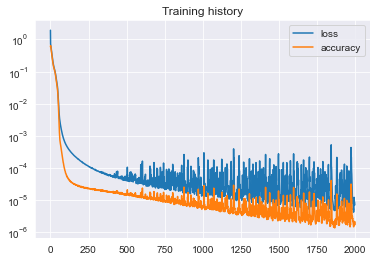

In [15]:
model = init_model()
model.summary()

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([600,1000],[1e-3,7.5e-4,5e-4])
model.compile(loss=PINN_cost,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['mse'],
              run_eagerly=False)  # DEFAULT IN tensorflow2.x

batch_size = round(.2*X_train.shape[0])
epochs = 2000
t_start = datetime.now()
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size = batch_size,
                    verbose = 0)
t_end = datetime.now()
print(t_end - t_start)


# plot history
plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['mse'], label = 'accuracy')
plt.legend()
plt.yscale('log')
plt.title('Training history')

Test the model on a new set of test points

79/79 [==============================] - 0s 1ms/step
mse = 3.2034755105374423e-07


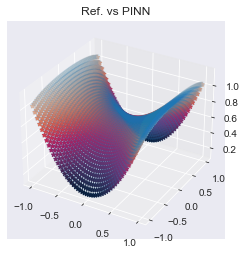

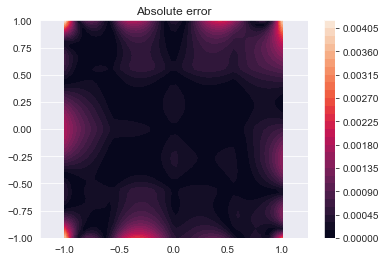

In [16]:
# new grid for testing
x_grid = np.linspace(-1,1,50).T
y_grid = np.linspace(-1,1,50).T
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
X_test = np.column_stack((X_grid.reshape(-1,1),Y_grid.reshape(-1,1)))

sol_PINN = model.predict(X_test)
sol_ref = res.interpolate(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(sol_PINN, sol_ref.reshape(-1, 1))
print('mse =', mse)

# Ref. vs PINN
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_test[:,0],X_test[:,1],sol_PINN,c = sol_PINN,marker = '*', alpha = 1)
ax.scatter(X_test[:, 0], X_test[:, 1], sol_ref, marker='o', alpha=.1)
plt.title('Ref. vs PINN')
plt.show()

plt.figure()
plt.contourf(X_grid, Y_grid, np.reshape(
    abs(sol_PINN - sol_ref.reshape(-1, 1)), X_grid.shape), 30)
plt.axis('equal')
plt.colorbar()
plt.title('Absolute error')
plt.show()
